In [15]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow
import itertools

from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Conv1D, MaxPooling1D, Activation, Flatten
from tqdm import tqdm
from collections import Counter
from eunjeon import Mecab
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer

In [2]:
stopwords = pd.read_csv('../stopword.csv')

상폐기업뉴스 = pd.read_csv('../../뉴스전처리/상폐기업뉴스전처리.csv')
상폐기업뉴스추가 = pd.read_csv('../../뉴스전처리/상폐기업뉴스전처리추가.csv')
상폐기업뉴스 = pd.concat([상폐기업뉴스, 상폐기업뉴스추가])

정상기업뉴스 = pd.read_csv('../../뉴스전처리/정상기업뉴스전처리.csv', encoding='cp949')
정상기업뉴스추가 = pd.read_csv('../../뉴스전처리/정상기업뉴스전처리추가.csv')
정상기업뉴스 = pd.concat([정상기업뉴스, 정상기업뉴스추가])

뉴스 = pd.concat([정상기업뉴스, 상폐기업뉴스])
뉴스.reset_index(drop=True, inplace=True)
뉴스

,기업,기사발행일,기사제목,뉴스기사본문전처리
0,씨제이이엔엠,2011.12.13. 오전 8:24,"씨제이이엔엠, 유형자산 취득 후 처분 예정",씨제이이엔엠은 억 만원 규모의 유형자산을 취득한다고 일 공시했다. 판교신도시 특별계...
1,씨제이이엔엠,2011.11.17. 오전 8:47,시초가 소폭 하락 예상 - 코스닥 동시호가,일 코스닥 시장은 소폭 하락 출발이 예상된다.코스닥 시장은 현재 시가총액 상위 종목...
2,안랩,2011.12.06. 오전 10:35,"안랩, `V3ㆍ네트워크 보안장비 연동` 특허 획득",안철수연구소는 네트워크 통합보안 장비 트러스가드에 적용된 기술인 단말 장치 및 상기...
3,안랩,2011.10.10. 오후 3:03,"한컴과 안랩, 10월은 특별한 달",월을 맞아 국내 대표 소프트웨어 업체들이 잇따라 재도약을 선언하며 성장세를 끌어올리...
4,포스코아이씨티,2011.08.31. 오전 10:32,"포스코아이씨티, POSCO IT Outsourcing SLA 계약금액 증가",포스코아이씨티는 일 지난 년 월 일 공시한 년 계약관련 계약금액을 억 만 원...
...,...,...,...,...
15371,코썬바이오,2020.01.10. 오후 7:40,"코썬바이오, 불성실공시법인 지정",한국거래소 코스닥시장본부는 일 코썬바이오가 지난해 월 최대주주 변경을 수반하는 주...
15372,코썬바이오,2019.12.20. 오후 6:53,"거래소, 코썬바이오 불성실 공시법인 지정…23일 주식거래 정지",한국거래소 코스닥시장본부는 오는 일 코썬바이오를 불성실 공시 법인으로 지정한다고 ...
15373,코썬바이오,2019.12.23. 오후 5:17,코썬바이오 불성실 공시법인 지정예고,코썬바이오는 공시불이행으로 불성실 공시법인으로 지정예고 됐다고 일 공시했다.사유는 ...
15374,코썬바이오,2019.12.23. 오후 5:23,"거래소, 코썬바이오 불성실 공시법인 지정예고",한국거래소 코스닥시장본부는 코썬바이오가 공시불이행에 따라 불성실 공시법인으로 지정...


In [3]:
mecab = Mecab()
# Mecab으로 토큰화
뉴스['뉴스기사본문전처리'] = 뉴스['뉴스기사본문전처리'].apply(lambda x: mecab.morphs(x))
# 한 글자 단어 제거
뉴스['뉴스기사본문전처리'] = 뉴스['뉴스기사본문전처리'].apply(lambda x: [word for word in x if len(word) > 1])
# stopwords에 있는 불용어 제거
뉴스['뉴스기사본문전처리'] = 뉴스['뉴스기사본문전처리'].apply(lambda x: [word for word in x if word not in stopwords])
뉴스

,기업,기사발행일,기사제목,뉴스기사본문전처리
0,씨제이이엔엠,2011.12.13. 오전 8:24,"씨제이이엔엠, 유형자산 취득 후 처분 예정","[씨제이, 규모, 유형, 자산, 취득, 한다고, 공시, 판교, 도시, 특별, 계획,..."
1,씨제이이엔엠,2011.11.17. 오전 8:47,시초가 소폭 하락 예상 - 코스닥 동시호가,"[코스닥, 시장, 소폭, 하락, 출발, 예상, 된다, 코스닥, 시장, 현재, 시가총..."
2,안랩,2011.12.06. 오전 10:35,"안랩, `V3ㆍ네트워크 보안장비 연동` 특허 획득","[안철수연구소, 네트워크, 통합, 보안, 장비, 트러스, 가드, 적용, 기술, 단말..."
3,안랩,2011.10.10. 오후 3:03,"한컴과 안랩, 10월은 특별한 달","[국내, 대표, 소프트웨어, 업체, 잇따라, 도약, 선언, 성장세, 끌어올리, 위해..."
4,포스코아이씨티,2011.08.31. 오전 10:32,"포스코아이씨티, POSCO IT Outsourcing SLA 계약금액 증가","[포스코, 아이, 씨티, 지난, 계약, 관련, 계약, 금액, 으로, 정정, 공시, ..."
...,...,...,...,...
15371,코썬바이오,2020.01.10. 오후 7:40,"코썬바이오, 불성실공시법인 지정","[한국, 거래소, 코스닥, 시장, 본부, 바이오, 지난해, 최대, 주주, 변경, 수..."
15372,코썬바이오,2019.12.20. 오후 6:53,"거래소, 코썬바이오 불성실 공시법인 지정…23일 주식거래 정지","[한국, 거래소, 코스닥, 시장, 본부, 바이오, 성실, 공시, 법인, 으로, 지정..."
15373,코썬바이오,2019.12.23. 오후 5:17,코썬바이오 불성실 공시법인 지정예고,"[공시, 불이행, 으로, 성실, 공시, 법인, 으로, 지정, 예고, 다고, 공시, ..."
15374,코썬바이오,2019.12.23. 오후 5:23,"거래소, 코썬바이오 불성실 공시법인 지정예고","[한국, 거래소, 코스닥, 시장, 본부, 바이오, 공시, 불이행, 따라, 성실, 공..."


기사의 최대 길이 : 2959
기사의 평균 길이 : 184.7557232049948


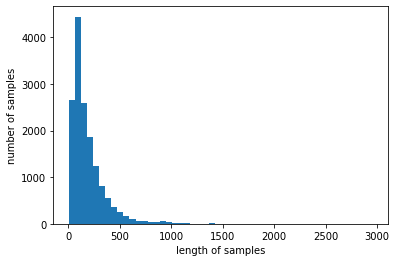

In [4]:
print('기사의 최대 길이 :',max(len(review) for review in 뉴스['뉴스기사본문전처리']))
print('기사의 평균 길이 :',sum(map(len, 뉴스['뉴스기사본문전처리']))/len(뉴스['뉴스기사본문전처리']))
plt.hist([len(review) for review in 뉴스['뉴스기사본문전처리']], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [5]:
분류단어 = ['폐지', '퇴출', '기로', '벼랑']
분류단어 = '|'.join(분류단어)
분류단어

'폐지|퇴출|기로|벼랑'

In [6]:
뉴스[뉴스['뉴스기사본문전처리'].str.contains('글로벌', na=False, case=False)]
라벨 = 뉴스['뉴스기사본문전처리'].apply(lambda x: [word for word in x if word in 분류단어])
라벨 = 라벨.apply(lambda x: 1 if (len(x)>=1) else 0)
뉴스['긍정부정기사분류'] = 라벨
뉴스

,기업,기사발행일,기사제목,뉴스기사본문전처리,긍정부정기사분류
0,씨제이이엔엠,2011.12.13. 오전 8:24,"씨제이이엔엠, 유형자산 취득 후 처분 예정","[씨제이, 규모, 유형, 자산, 취득, 한다고, 공시, 판교, 도시, 특별, 계획,...",0
1,씨제이이엔엠,2011.11.17. 오전 8:47,시초가 소폭 하락 예상 - 코스닥 동시호가,"[코스닥, 시장, 소폭, 하락, 출발, 예상, 된다, 코스닥, 시장, 현재, 시가총...",0
2,안랩,2011.12.06. 오전 10:35,"안랩, `V3ㆍ네트워크 보안장비 연동` 특허 획득","[안철수연구소, 네트워크, 통합, 보안, 장비, 트러스, 가드, 적용, 기술, 단말...",0
3,안랩,2011.10.10. 오후 3:03,"한컴과 안랩, 10월은 특별한 달","[국내, 대표, 소프트웨어, 업체, 잇따라, 도약, 선언, 성장세, 끌어올리, 위해...",0
4,포스코아이씨티,2011.08.31. 오전 10:32,"포스코아이씨티, POSCO IT Outsourcing SLA 계약금액 증가","[포스코, 아이, 씨티, 지난, 계약, 관련, 계약, 금액, 으로, 정정, 공시, ...",0
...,...,...,...,...,...
15371,코썬바이오,2020.01.10. 오후 7:40,"코썬바이오, 불성실공시법인 지정","[한국, 거래소, 코스닥, 시장, 본부, 바이오, 지난해, 최대, 주주, 변경, 수...",0
15372,코썬바이오,2019.12.20. 오후 6:53,"거래소, 코썬바이오 불성실 공시법인 지정…23일 주식거래 정지","[한국, 거래소, 코스닥, 시장, 본부, 바이오, 성실, 공시, 법인, 으로, 지정...",0
15373,코썬바이오,2019.12.23. 오후 5:17,코썬바이오 불성실 공시법인 지정예고,"[공시, 불이행, 으로, 성실, 공시, 법인, 으로, 지정, 예고, 다고, 공시, ...",0
15374,코썬바이오,2019.12.23. 오후 5:23,"거래소, 코썬바이오 불성실 공시법인 지정예고","[한국, 거래소, 코스닥, 시장, 본부, 바이오, 공시, 불이행, 따라, 성실, 공...",0


In [7]:
remove_one_word = [x for x in 뉴스['뉴스기사본문전처리'] if len(x) > 1]
remove_one_word = list(itertools.chain(*remove_one_word))
remove_one_word

frequent = Counter(remove_one_word).most_common()

minimum_words = []
for item, count in frequent:
    if count <= 10:
        minimum_words.append(item)
minimum_words = '|'.join(minimum_words)

뉴스['뉴스기사본문전처리'] = 뉴스['뉴스기사본문전처리'].apply(lambda x: [word for word in x if word not in minimum_words])

기사의 최대 길이 : 971
기사의 평균 길이 : 58.61446409989594


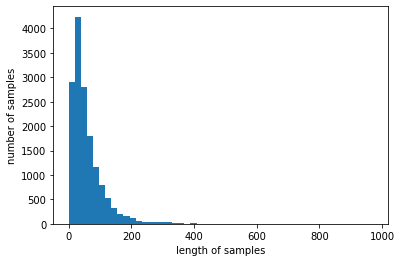

In [8]:
print('기사의 최대 길이 :',max(len(review) for review in 뉴스['뉴스기사본문전처리']))
print('기사의 평균 길이 :',sum(map(len, 뉴스['뉴스기사본문전처리']))/len(뉴스['뉴스기사본문전처리']))
plt.hist([len(review) for review in 뉴스['뉴스기사본문전처리']], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [9]:
x_train, x_test, y_train, y_test = train_test_split(뉴스['뉴스기사본문전처리'], 뉴스['긍정부정기사분류'], random_state=42, test_size=0.2, stratify = 뉴스['긍정부정기사분류'])
max_review_length = 100

tokenizer = Tokenizer ()
tokenizer.fit_on_texts(뉴스['뉴스기사본문전처리'])
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

x_train = sequence.pad_sequences(x_train, maxlen=max_review_length)
x_test = sequence.pad_sequences(x_test, maxlen=max_review_length)

smote = SMOTE()
x_train, y_train = smote.fit_resample(x_train, y_train)
#x_test, y_test = smote.fit_resample(x_test, y_test)

print("Shape of train data:", x_train.shape)
print("Shape of Test data:", x_test.shape)

Shape of train data: (22044, 100)
Shape of Test data: (3076, 100)


In [17]:
# 모델의 설정
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=32, input_length=max_review_length))
model.add(Dropout(0.5))
# strides : 컨볼루션 커널 이동 간격 / 보폭
model.add(Conv1D(64, 5, padding='valid', activation="relu", strides=1))
model.add(MaxPooling1D(pool_size=4))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
# 새로운 방식
model.add(Dense(1))
model.add(Activation("sigmoid"))

model.compile(optimizer='adam',
	 loss='binary_crossentropy',
	 metrics=['accuracy',
	 		tensorflow.keras.metrics.Recall(),
			tensorflow.keras.metrics.Precision()
			])
        
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 32)           320000    
                                                                 
 dropout_4 (Dropout)         (None, 100, 32)           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 96, 64)            10304     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 24, 64)           0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1536)              0         
                                                                 
 dense_4 (Dense)             (None, 10)                15370     
                                                      

In [18]:
import os
from keras.callbacks import ModelCheckpoint, EarlyStopping

MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

modelpath = './model/{epoch:02d}-{val_loss:4f}.hdf5'
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10,
batch_size=32, verbose=0, callbacks=[early_stopping_callback, checkpointer])

#print('\n Test F1 Score : %.4f' % (model.evaluate(x_test, y_test)))
print(model.evaluate(x_test, y_test))


Epoch 1: val_loss improved from inf to 0.25617, saving model to ./model\01-0.256174.hdf5

Epoch 2: val_loss improved from 0.25617 to 0.19584, saving model to ./model\02-0.195844.hdf5

Epoch 3: val_loss did not improve from 0.19584

Epoch 4: val_loss did not improve from 0.19584

Epoch 5: val_loss did not improve from 0.19584
97/97 [==============================] - 0s 2ms/step - loss: 0.2501 - accuracy: 0.9256 - recall_3: 0.6969 - precision_3: 0.6282
[0.25009045004844666, 0.9255526661872864, 0.6968749761581421, 0.6281690001487732]


In [20]:
predict = model.predict(x_test)
predict = [1 if score >= 0.5 else 0 for score in predict]
f1 = f1_score(predict, y_test)
f1

97/97 [==============================] - 0s 3ms/step


0.6607407407407409